In [1]:
import networkx as nx
import matplotlib.pyplot as plt


# Defining a Class
class GraphVisualization:

    def __init__(self):

        # visual is a list which stores all
        # the set of edges that constitutes a
        # graph
        self.visual = []

    # addEdge function inputs the vertices of an
    # edge and appends it to the visual list
    def addEdge(self, a, b):
        temp = [a, b]
        self.visual.append(temp)

    # In visualize function G is an object of
    # class Graph given by networkx G.add_edges_from(visual)
    # creates a graph with a given list
    # nx.draw_networkx(G) - plots the graph
    # plt.show() - displays the graph
    def visualize(self):
        G = nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()
def showModel(model):
    G = GraphVisualization()
    for i in range(len(model)):
        for j in range(i):
            if(model[i][j]!=0):
                G.addEdge(i,j);
    G.visualize()

In [22]:
import numpy as np
from scipy.special import expit as logsig
from scipy.stats import binom
import random
import matplotlib.pyplot as plt

def sampling_ising(A, N):
    """
    Sample from an Ising model with weight matrix A
    A is the weight matrix, A_ij = A_ji, assuming the mean-field = 0
    """
    s = A.shape[0]
    all_states = np.array([(np.array(list(bin(i)[2:].zfill(s)), dtype=int)*2-1) for i in range(2**s)])  #generates all states
    probs = np.array([np.exp(x @ A @ x.T / 2) for x in all_states])
    probs = probs / probs.sum()
    samples_idx = np.random.choice(2**s, size=N, p=probs)
    samples = all_states[samples_idx]           #maps index of chosen state to actual state
    return samples

def sampling_diamond(s, theta, rand_sign, num_sample):
    """
    Sampling from an Ising model with diamond graph structure
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    """
    A = np.zeros((s, s))
    A[0, 1:s-1] = theta
    A[s-1, 1:s-1] = theta
    A[1:s-1, 0] = theta
    A[1:s-1, s-1] = theta
    if rand_sign:
        sign_mat = np.triu((binom.rvs(1, 0.5, size=(s, s))*2-1), 1)
        A = A * (sign_mat + sign_mat.T)  # make it symmetric

    samples = sampling_ising(A, num_sample)
    showModel(A)
    return A, samples
def genDDegreeGraph(s, theta, rand_sign, num_sample,d):
    G = nx.random_regular_graph(d=d,n=s);
    A = np.zeros((s, s))
    for i in range(s):
        for j in range(s):
            if i!=j and G.has_edge(i,j):
                A[i][j] = theta*(-1 if rand_sign and random.random()<.5 else 1)
    return A
def showMat(model):
    for i in range(len(model)):
        for j in range(len(model)):
            try:
                print("{0:.4f}".format(model[i][j]),end = " ")
            except:
                print(model[i][j],end=" ")
        print()

def mirror_descent(X, y, T, W1):
    """
    Use mirror descent to solve a logistic regression problem
    with simplex constraint:
    x_{t+1} = x_t exp(-eta*grad), x_{t+1} = x_{t+1} / ||x_{t+1}||_1
    """
    d = X.shape[1]
    N = X.shape[0]
    eta = np.sqrt(2 * np.log(d) / T) / (2 * W1)
    w = np.ones(d) / d
    w_sum = w.copy()

    for t in range(T):
        preds = logsig(X @ w) - y
        grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)  # could use stochastic gradient
        w = w * np.exp(-eta * grad)
        w = w / w.sum()
        w_sum = w_sum + w

    w_avg = w_sum / T
    # compute the gradient norm at w_avg
    preds = logsig(X @ w_avg) - y
    grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)
    g_norm = np.linalg.norm(grad)

    return w_avg, g_norm

def ising_learn(graph_size, num_sample, theta, rand_sign, num_iter):
    """
    graph_size: indicates the size of the graph; theta: weight of each edge
    if rand_sign = True, then the sign of each edge weight is random
    if rand_sign = False, then all edge weights = theta
    num_samples: number of samples; num_iter: number of mirror descent iterations
    """
    s = graph_size
    A, Xs = sampling_diamond(s, theta, rand_sign, num_sample)
    W1 = 2 * (s - 2) * theta
    A_hat = np.zeros((s, s))
    for i in range(s):
        y = (Xs[:, i] + 1) / 2
        X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        print(X)
        w, _ = mirror_descent(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
    showModel(A)
    showMat(A_hat)
    # showModel([[A_hat[i][j]>.001 for j in range(s)]for i in range(s)])
    error = np.max(np.abs(A - A_hat))
    return error

In [62]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def makeDDegree(s,A_hat):
    topEdges = sorted([(abs(A_hat[i,j]),i,j) for j in range(s) for i in range(s)],reverse=True)
    out = np.zeros((s, s))
    degree = [0]*s;
    for weight,i,j in topEdges:
        if out[i][j]==0 and degree[i]<d and degree[j]<d:
            degree[i]+=1
            degree[j]+=1
            out[i][j] = A_hat[i,j]
            out[j][i] = out[i][j]
    return out
def learn(samples,num_iter,W1):
    s = len(samples[0])
    num_sample=len(samples)
    gamma = np.sqrt(2*np.log(2*s+1)/num_iter)/2/W1
    A = np.zeros((s,s));
    for i in range(s):
        # w = np.ones(2*s-1)/(2*s-1)
        w=np.random.rand(2*s-1)
        w/=sum(abs(w))
        iter=0;
        for t in range(num_iter):
            prev= w.copy()
            grad = np.zeros(2*s-1);
            for sample_ind in range(num_sample):
                x = np.hstack([samples[sample_ind][:i],samples[sample_ind][i+1:]])
                x = np.hstack([x,-x,np.zeros(1)])*W1
                y = samples[sample_ind][i]
                grad+=(sigmoid(w @ x.T)-y)*x/num_sample
                # print(w,x,w @ x)
            w*=np.exp(-gamma*grad)
            w/=sum(abs(w))
            iter+=1
            if max(abs(w-prev))<.001:
                break
        w/=iter
        for p in range(s):
            if p==i:
                continue
            A[i,p] = (w[p-(p>i)]-w[p-(p>i)+s-1])*W1/2
    return A
def mirrorDescentSelfStopping(X, y, T, W1):
    """
    Use mirror descent to solve a logistic regression problem
    with simplex constraint:
    x_{t+1} = x_t exp(-eta*grad), x_{t+1} = x_{t+1} / ||x_{t+1}||_1
    """
    d = X.shape[1]
    N = X.shape[0]
    eta = np.sqrt(2 * np.log(d) / T) / (2 * W1)
    w = np.ones(d) / d
    w_sum = w.copy()
    tot = T;
    for t in range(T):
        w_prev = w.copy()
        preds = logsig(X @ w) - y
        grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)  # could use stochastic gradient
        w = w * np.exp(-eta * grad)
        w = w / w.sum()
        w_sum = w_sum + w
        if max(abs(w-w_prev))<.001:
            tot = t+1;
            break

    w_avg = w_sum / tot
    # compute the gradient norm at w_avg
    preds = logsig(X @ w_avg) - y
    grad = (np.ones(N) / N) @ (preds.reshape(-1, 1) * X)
    g_norm = np.linalg.norm(grad)

    return w_avg, g_norm

In [4]:
def ising_learn_d_degree_graph_success(graph_size, samples, theta, num_iter,d,show = False):
    s = graph_size
    W1 = 2*d*theta
    # A_hat = learn(samples,num_iter,W1)
    # x = A_hat.copy()
    A_hat = np.zeros((s, s))
    num_sample = len(samples)
    for i in range(s):
        y = (samples[:, i] + 1) / 2
        X = np.hstack([samples[:, :i], samples[:, i+1:]])
        X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
        w, _ = mirrorDescentSelfStopping(X, y, num_iter, W1)
        w = (w[:s-1] - w[s-1:2*s-2]) * W1
        A_hat[i, :i] = w[:i] / 2
        A_hat[i, i+1:] = w[i:] / 2
    out = makeDDegree(s,A_hat)
    return out

In [5]:
# def ising_learn_d_degree_graph(graph_size, num_sample, theta, rand_sign, num_iter,d,show = False):
#     """
#     graph_size: indicates the size of the graph; theta: weight of each edge
#     if rand_sign = True, then the sign of each edge weight is random
#     if rand_sign = False, then all edge weights = theta
#     num_samples: number of samples; num_iter: number of mirror descent iterations
#     """
#     s = graph_size
#     A, Xs = dDegreeGraphSampling(s, theta, rand_sign, num_sample,d)
#     W1 = 2 * (s - 2) * theta
#     A_hat = np.zeros((s, s))

#     for i in range(s):
#         y = (Xs[:, i] + 1) / 2
#         X = np.hstack([Xs[:, :i], Xs[:, i+1:]])
#         X = np.hstack([X, -X, np.zeros((num_sample, 1))]) * W1
#         w, _ = mirror_descent(X, y, num_iter, W1)
#         w = (w[:s-1] - w[s-1:2*s-2]) * W1
#         A_hat[i, :i] = w[:i] / 2
#         A_hat[i, i+1:] = w[i:] / 2
#         topDedges = sorted([(A_hat[i,j],j) for j in range(s)])
#         A_hat[i,:] = np.zeros(s)
#         for k in range(d):
#             A_hat[i,topDedges[-k-1][1]] = topDedges[-k-1][0]
#     if show:
#         print("Actual graph")
#         showModel(A)
#         showMat(A)
#         print("predicted graph")
#         showModel([[A_hat[i][j]!=0 for j in range(s)]for i in range(s)])
#         showMat(A_hat)

#     error = np.max(np.abs(A - A_hat))
#     return error

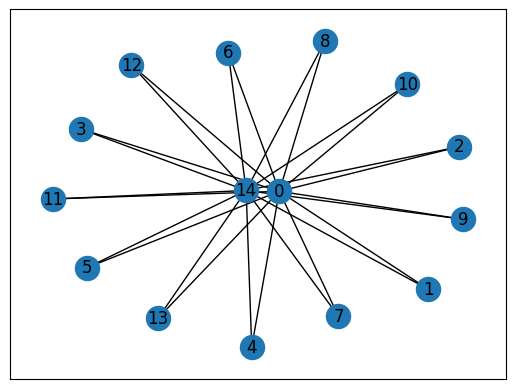

[[ 0.26 -0.26 -0.26 ...  0.26  0.26  0.  ]
 [-0.26  0.26  0.26 ...  0.26  0.26  0.  ]
 [-0.26 -0.26 -0.26 ...  0.26  0.26  0.  ]
 ...
 [-0.26 -0.26  0.26 ... -0.26  0.26  0.  ]
 [-0.26 -0.26 -0.26 ... -0.26 -0.26  0.  ]
 [ 0.26  0.26  0.26 ...  0.26 -0.26  0.  ]]
[[-0.26 -0.26 -0.26 ...  0.26  0.26  0.  ]
 [-0.26  0.26  0.26 ...  0.26  0.26  0.  ]
 [ 0.26 -0.26 -0.26 ...  0.26  0.26  0.  ]
 ...
 [ 0.26 -0.26  0.26 ... -0.26  0.26  0.  ]
 [-0.26 -0.26 -0.26 ... -0.26 -0.26  0.  ]
 [ 0.26  0.26  0.26 ...  0.26 -0.26  0.  ]]
[[-0.26  0.26 -0.26 ...  0.26  0.26  0.  ]
 [-0.26 -0.26  0.26 ...  0.26  0.26  0.  ]
 [ 0.26 -0.26 -0.26 ...  0.26  0.26  0.  ]
 ...
 [ 0.26 -0.26  0.26 ... -0.26  0.26  0.  ]
 [-0.26 -0.26 -0.26 ... -0.26 -0.26  0.  ]
 [ 0.26  0.26  0.26 ...  0.26 -0.26  0.  ]]
[[-0.26  0.26 -0.26 ...  0.26  0.26  0.  ]
 [-0.26 -0.26  0.26 ...  0.26  0.26  0.  ]
 [ 0.26 -0.26 -0.26 ...  0.26  0.26  0.  ]
 ...
 [ 0.26 -0.26 -0.26 ... -0.26  0.26  0.  ]
 [-0.26 -0.26 -0.26 ... -0.26 -

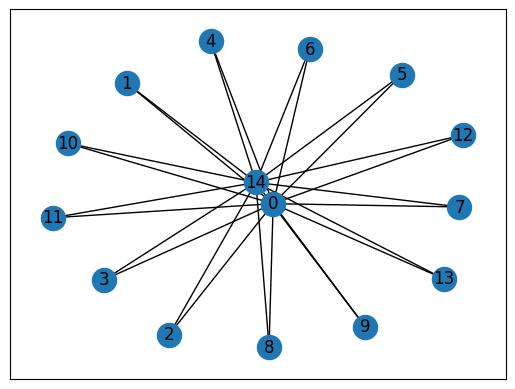

0.0000 0.0001 -0.0012 0.0008 -0.0000 0.0004 0.0012 -0.0033 0.0003 -0.0001 0.0014 0.0009 -0.0026 -0.0003 0.0011 
0.0001 0.0000 0.0006 -0.0003 -0.0012 -0.0006 -0.0010 0.0001 -0.0005 -0.0017 0.0006 -0.0010 0.0005 -0.0001 0.0017 
-0.0012 0.0006 0.0000 0.0004 0.0002 0.0003 0.0001 0.0007 0.0005 0.0007 0.0006 0.0007 0.0012 -0.0007 0.0013 
0.0008 -0.0003 0.0004 0.0000 -0.0003 -0.0006 0.0003 -0.0002 -0.0003 0.0012 0.0028 0.0001 0.0000 -0.0006 -0.0010 
-0.0000 -0.0012 0.0002 -0.0003 0.0000 0.0002 -0.0003 0.0005 0.0010 -0.0007 -0.0001 0.0003 -0.0009 -0.0005 -0.0005 
0.0004 -0.0006 0.0003 -0.0006 0.0002 0.0000 -0.0002 0.0001 -0.0010 -0.0007 0.0001 -0.0011 0.0009 -0.0003 -0.0002 
0.0013 -0.0010 0.0001 0.0003 -0.0003 -0.0002 0.0000 -0.0013 -0.0016 -0.0012 -0.0014 0.0003 -0.0013 -0.0007 0.0002 
-0.0033 0.0001 0.0007 -0.0002 0.0005 0.0001 -0.0013 0.0000 -0.0008 0.0006 -0.0017 -0.0002 -0.0013 -0.0008 0.0011 
0.0003 -0.0005 0.0005 -0.0003 0.0010 -0.0010 -0.0016 -0.0008 0.0000 -0.0004 0.0003 -0.0015 0.00

In [6]:
# Parameters
graph_size = 15
num_sample = 1000
theta = 0.01
rand_sign = True
num_iter = 100

error = ising_learn(graph_size, num_sample, theta, rand_sign, num_iter)
print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")

#structure prediction

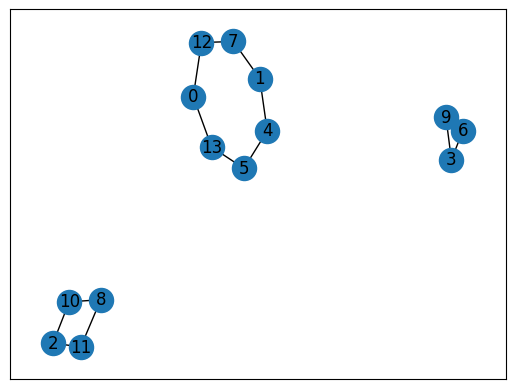

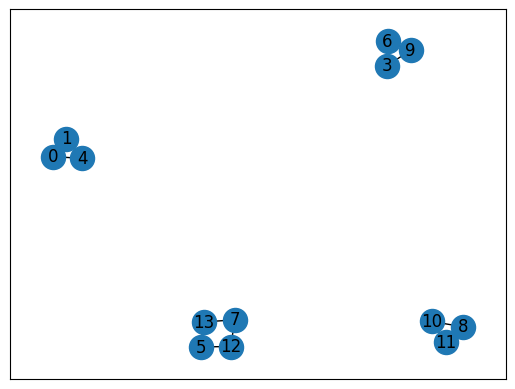

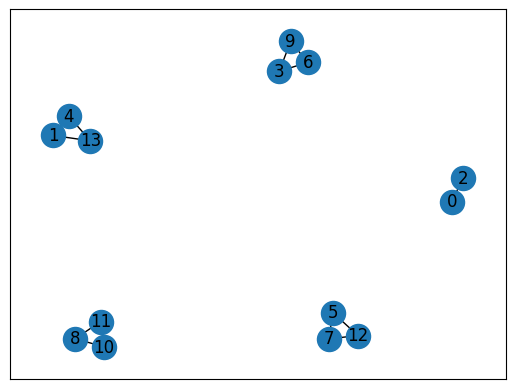

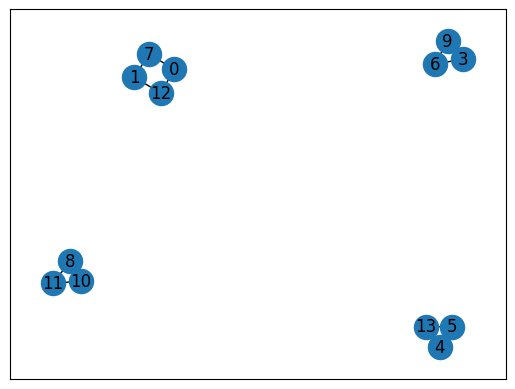

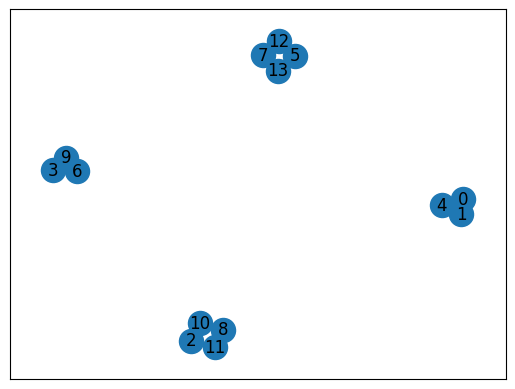

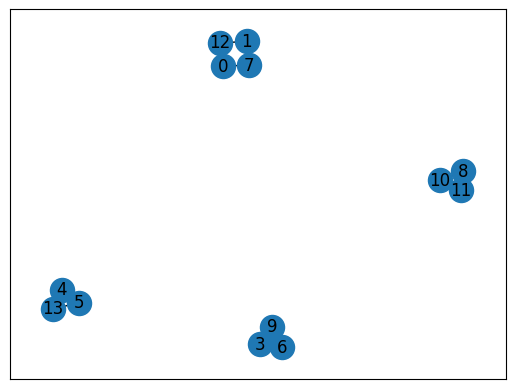

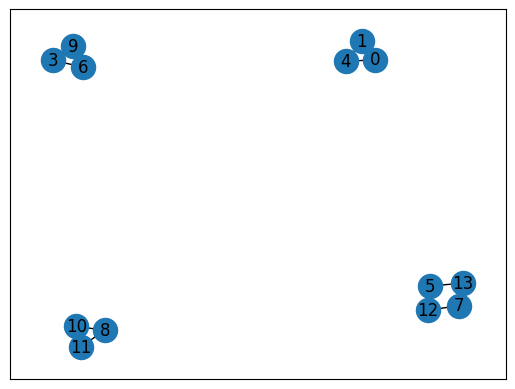

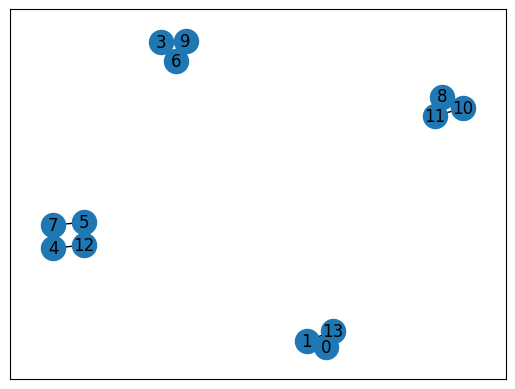

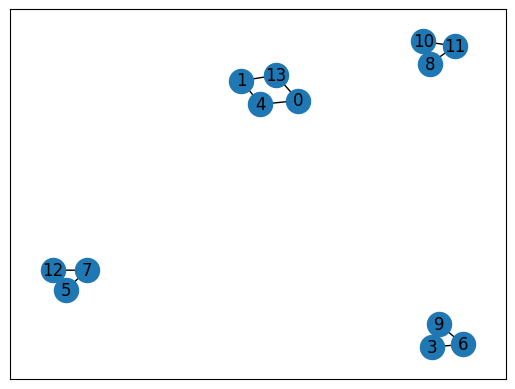

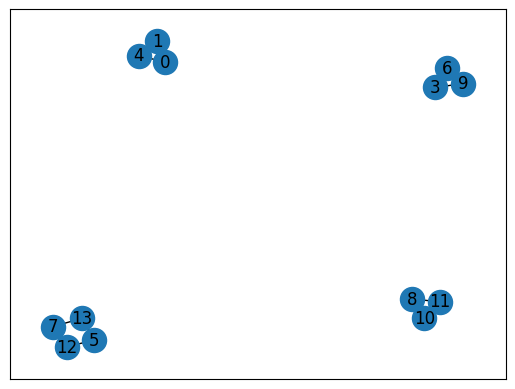

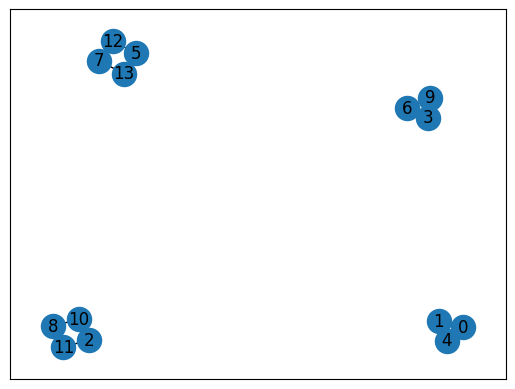

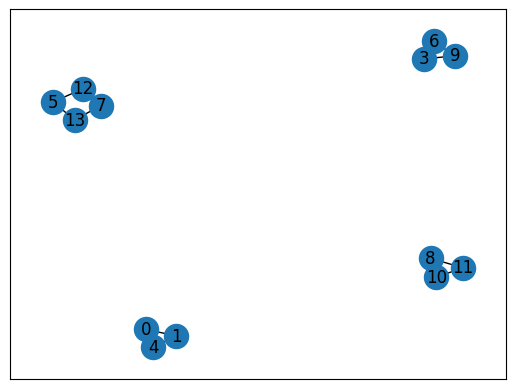

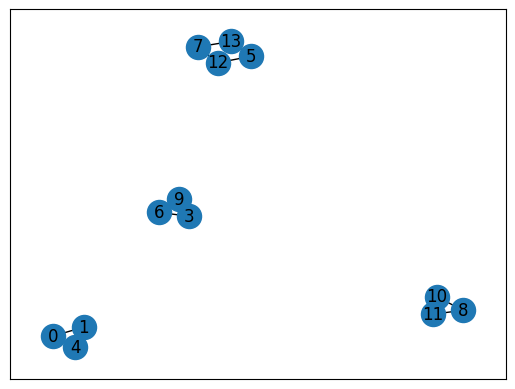

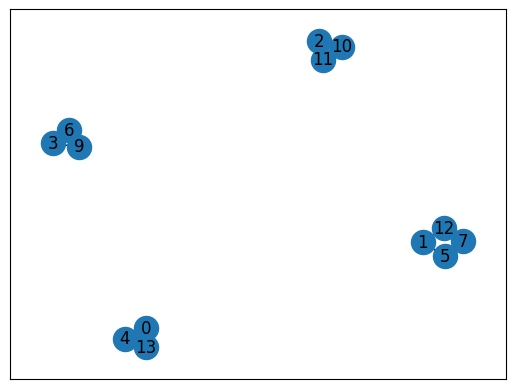

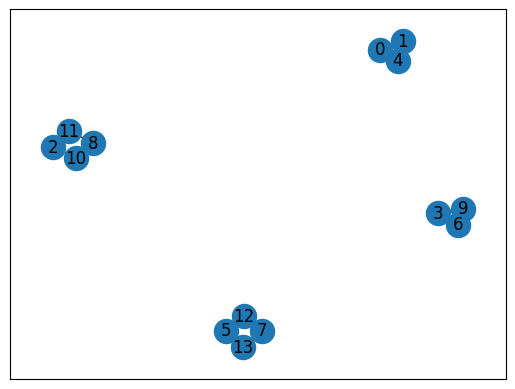

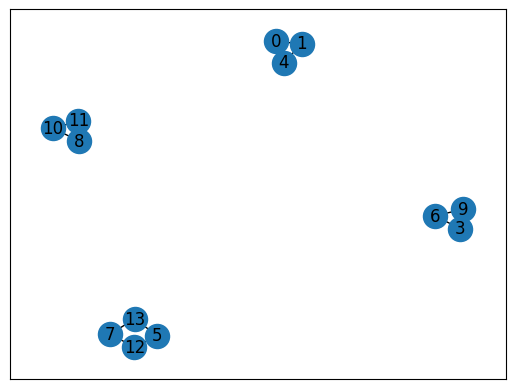

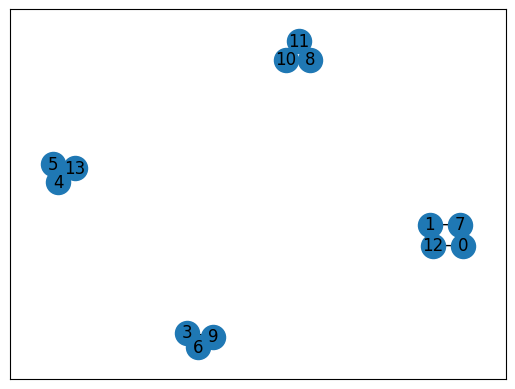

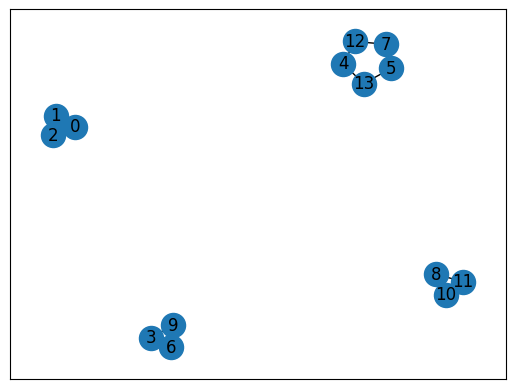

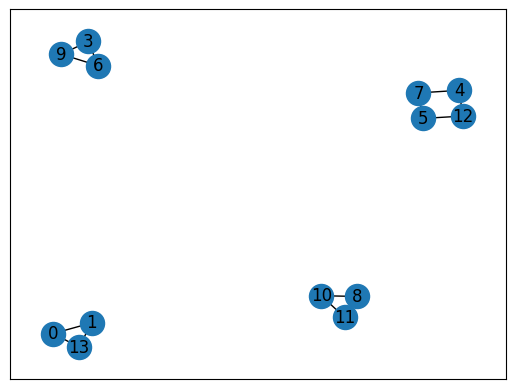

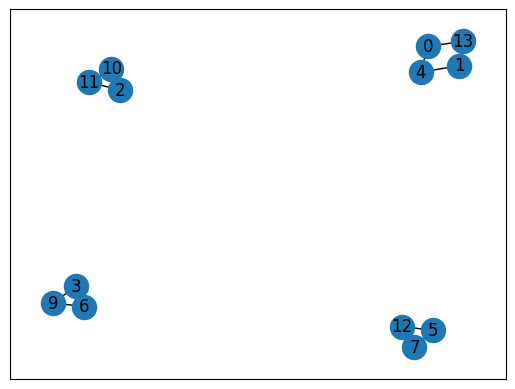

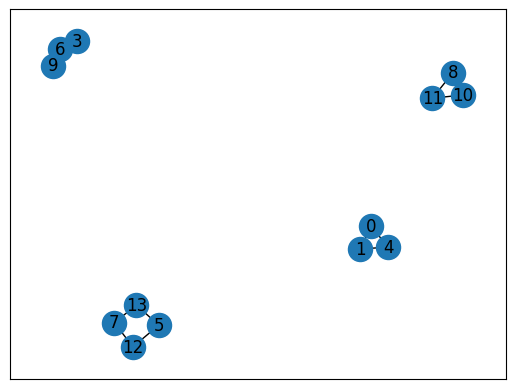

In [35]:
graph_size = 14
max_num_sample = 100000
theta =40
rand_sign = False
num_iter = 1000
d=2
model = genDDegreeGraph(graph_size,theta,rand_sign,num_sample,d)
showModel(model)
for i in range(20):
    samples = sampling_ising(model,max_num_sample)
    out = ising_learn_d_degree_graph_success(graph_size, samples, theta, num_iter,d)
    # showMat(out)
    showModel(out)


#divergence optimisation

In [8]:
def getDivergence(A, B):
    s = A.shape[0]
    all_states = np.array([(np.array(list(bin(i)[2:].zfill(s)), dtype=int)*2-1) for i in range(2**s)])  #generates all states
    div=0;
    probsA = np.array([np.exp(x @ A @ x.T / 2) for x in all_states])
    probsA = probsA / probsA.sum()
    probsB = np.array([np.exp(x @ B @ x.T / 2) for x in all_states])
    probsB = probsB / probsB.sum()
    for i in range(2**s):
        div+=probsA[i]*np.log(probsA[i]/probsB[i]);
    return div

In [44]:
graph_size = 14
max_num_sample = 100000
theta = .1
rand_sign = True
num_iter = 1000
d=3
model = genDDegreeGraph(graph_size,theta,rand_sign,num_sample,d)
threshold = .035
l,r = 1,12
samples = sampling_ising(model,max_num_sample)
for m in [100,100000]:
    # m = int((l+r)/2)
    out = ising_learn_d_degree_graph_success(graph_size, samples[:m], theta, num_iter,d)
    div = getDivergence(model,out)
    print("divergence is ",div)
    if div<threshold:
        r=m
    else:
        l=m
    # print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")
print("final range - ",l,r)


divergence is  0.06767965924237683
divergence is  0.06461295411680851
final range -  100000 12


In [63]:
def getSampleEstimate(theta,showDiv = False):
    graph_size = 14
    max_num_sample = 100000
    rand_sign = True
    num_iter = 500
    d=3
    model = genDDegreeGraph(graph_size,theta,rand_sign,num_sample,d)
    l,r = 1,max_num_sample
    samples = sampling_ising(model,max_num_sample)
    while l<r-10:
        m = int((l+r)/2)
        out = ising_learn_d_degree_graph_success(graph_size, samples[:m], theta, num_iter,d)
        div = getDivergence(model,out)
        if showDiv:
            print("divergence is ",div,m)
        if div<threshold:
            r=m
        else:
            l=m
    return (l+r)//2
    # print(f"Maximum absolute error between true and estimated adjacency matrices: {error:.4f}")
threshold = .072
getSampleEstimate(.075,True)

divergence is  0.02521764949312365 50000
divergence is  0.025217310729266276 25000
divergence is  0.02521778092939237 12500
divergence is  0.025217528379809406 6250
divergence is  0.025219179206987265 3125
divergence is  0.025219405757789994 1563
divergence is  0.025217408165553096 782
divergence is  0.02522143007326577 391
divergence is  0.025216802893920916 196
divergence is  0.02523097139784288 98
divergence is  0.02523757858781982 49
divergence is  0.02523286905247724 25
divergence is  0.025229037955871697 13
divergence is  0.025221156138437457 7


4

analysing theta =	 0.065
trial 	 0
divergence is  0.02371275552821081 50000
divergence is  0.02371308917082206 25000
divergence is  0.023713651716618142 12500
divergence is  0.02371320394625283 6250
divergence is  0.02371347383283982 3125
divergence is  0.023714145589584467 1563
divergence is  0.023715323750334374 782
divergence is  0.023716643736315268 391
divergence is  0.023709246044508872 196
divergence is  0.02372303001818742 98
divergence is  0.023732264341021086 49
divergence is  0.02372381577612984 25
divergence is  0.023751816300810368 13
divergence is  0.029214659357097193 7
trial 	 1
divergence is  0.0247315248333767 50000
divergence is  0.02473221626632389 25000
divergence is  0.024732712518808382 12500
divergence is  0.024731016663924865 6250
divergence is  0.024728563960738154 3125
divergence is  0.024729477805940564 1563
divergence is  0.024729598593981012 782
divergence is  0.024742360771449128 391
divergence is  0.02474777195301585 196
divergence is  0.0247377158002487

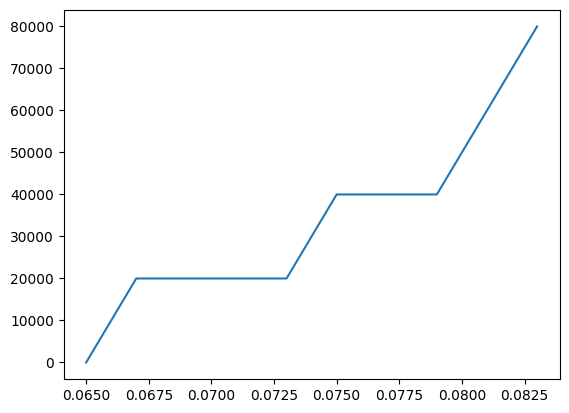

[0.065, 0.067, 0.06899999999999999, 0.071, 0.073, 0.075, 0.077, 0.079, 0.081, 0.08299999999999999] [4.0, 20003.6, 20003.6, 20006.0, 20006.0, 40003.2, 40003.200000000004, 40003.2, 60000.40000000001, 79998.8]


In [78]:
import matplotlib.pyplot as plt
x,y = [],[]
size=5
threshold=.031
meanTheta = .075
delta = .002
iter = 10
for i in range(iter):
    theta= meanTheta+(i-iter//2)*delta
    print("analysing theta =\t",theta)
    s=0
    for _ in range(size):
        print("trial \t",_)
        s+=getSampleEstimate(theta,True)/size
    x.append(theta)
    y.append(s)
    theta+=.005
plt.plot(x,y)
plt.show()
print(x,y)

[4.0, 20003.6, 20003.6, 20006.0, 20006.0, 40003.2, 40003.200000000004, 40003.2, 60000.40000000001, 79998.8]
[ 1.38629436  9.90366754  9.90366754  9.90378751  9.90378751 10.59671473
 10.59671473 10.59671473 11.00210651 11.28976691]
[0.065, 0.067, 0.06899999999999999, 0.071, 0.073, 0.075, 0.077, 0.079, 0.081, 0.08299999999999999]


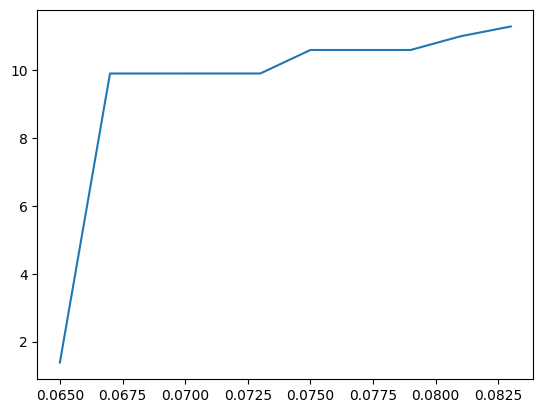

0.065 1.3862943611198906
0.067 9.903667536338071
0.06899999999999999 9.903667536338071
0.071 9.903787507545125
0.073 9.903787507545125
0.075 10.596714729896243
0.077 10.596714729896243
0.079 10.596714729896243
0.081 11.002106507848682
0.08299999999999999 11.289766913543518


In [82]:
print(y)
print(np.log(y))
print(x)
plt.plot(x,np.log(y))
plt.show()
for i in range(len(x)):
    print(x[i],np.log(y)[i])

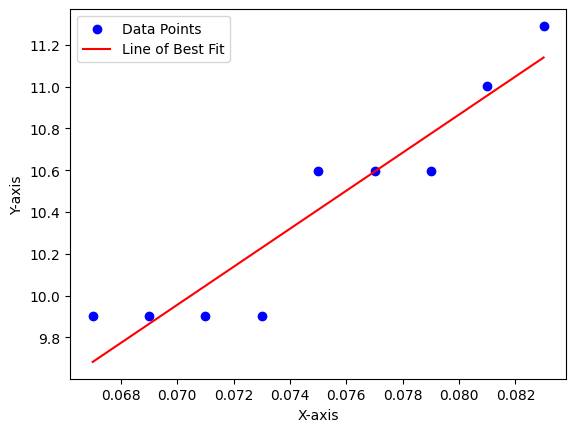

90.98746742005784 3.5867096878120335


In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
X = np.array(x,dtype = float)
Y = y.copy()
X = np.hstack([X[1:],X[5:4]])
Y = np.hstack([Y[1:],Y[5:4]])
# Calculate the line of best fit
m, c = np.polyfit(X, np.log(Y), 1)

# Plot the scatter plot
plt.scatter(X, np.log(Y), color='blue', label='Data Points')

# Plot the line of best fit
plt.plot(X, m*X + c, color='red', label='Line of Best Fit')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()
print(m,c)

analysing theta =	 0.05
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.055
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.06
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.065
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.07
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.07500000000000001
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.08000000000000002
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.08500000000000002
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.09000000000000002
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4
analysing theta =	 0.09500000000000003
trial 	 0
trial 	 1
trial 	 2
trial 	 3
trial 	 4


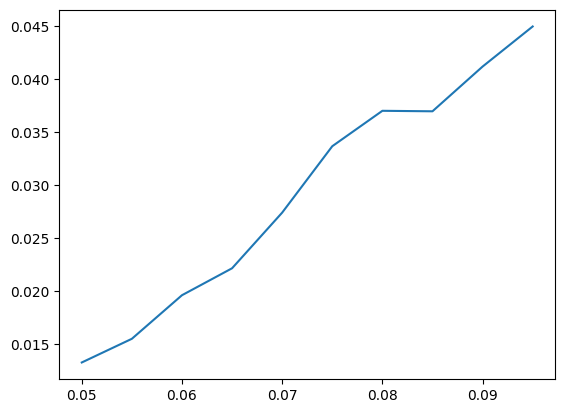

[0.05, 0.055, 0.06, 0.065, 0.07, 0.07500000000000001, 0.08000000000000002, 0.08500000000000002, 0.09000000000000002, 0.09500000000000003] [np.float64(0.013227630303204873), np.float64(0.015462599865263573), np.float64(0.01957435711005938), np.float64(0.022116910821690986), np.float64(0.027368465804254203), np.float64(0.033632833816615026), np.float64(0.03697458233658471), np.float64(0.03692817780468672), np.float64(0.04114845767437146), np.float64(0.04493142052033869)]


In [12]:
import matplotlib.pyplot as plt
xTheta,yTheta = [],[]
size=5
graph_size = 14
threshold=.031
theta = .05
num_sample = 10000
num_iter = 1000
rand_sign = True
d=3
while theta<.1:
    print("analysing theta =\t",theta)
    s=0

    for _ in range(size):
        print("trial \t",_)
        model = genDDegreeGraph(graph_size,theta,rand_sign,num_sample,d)
        out = ising_learn_d_degree_graph_success(graph_size, sampling_ising(model,num_sample), theta, num_iter,d)
        div = getDivergence(model,out)
        s+=div/size
    xTheta.append(theta)
    yTheta.append(s)
    theta+=.005
plt.plot(xTheta,yTheta)
plt.show()
print(xTheta,yTheta)

In [ ]:
def linearRegression(x, y):
    n = np.size(x)

    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)

    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x

    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x

    return (b_0, b_1)
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.scatter(x, y, color = "m",
        marker = "o", s = 30)

    # predicted response vector
    y_pred = b[0] + b[1]*x

    # plotting the regression line
    plt.plot(x, y_pred, color = "g")

    # putting labels
    plt.xlabel('x')
    plt.ylabel('y')
X = np.array(x.copy())
Y = np.log(np.array(y.copy()))
plot_regression_line(X,Y,linearRegression(X[:-2],Y[:-2]))
print(linearRegression(X[:-2],Y[:-2]))
plt.plot(X,Y)
plt.show()